<a href="https://colab.research.google.com/github/HakimSkaik/Autonomous-Car/blob/main/Behavioural_Cloning_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/HakimSkaik/Track.git


fatal: destination path 'Track' already exists and is not an empty directory.


In [ ]:
!ls Track

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random


In [ ]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  \
0  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_20_16_29_00_803.jpg   
1  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_20_16_29_00_906.jpg   
2  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_20_16_29_01_008.jpg   
3  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_20_16_29_01_109.jpg   
4  C:\Users\hakee\Downloads\Data Car\IMG\center_2022_10_20_16_29_01_210.jpg   

                                                                      left  \
0   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_20_16_29_00_803.jpg   
1   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_20_16_29_00_906.jpg   
2   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_20_16_29_01_008.jpg   
3   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_20_16_29_01_109.jpg   
4   C:\Users\hakee\Downloads\Data Car\IMG\left_2022_10_20_16_29_01_210.jpg   

                                                                      right  \
0   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_20_16_29_00_803.jpg   
1   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_20_16_29_00_906.jpg   
2   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_20_16_29_01_008.jpg   
3   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_20_16_29_01_109.jpg   
4   C:\Users\hakee\Downloads\Data Car\IMG\right_2022_10_20_16_29_01_210.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000078  
1  0.0       0.0       0.0      0.000084  
2  0.0       0.0       0.0      0.000078  
3  0.0       0.0       0.0      0.000080  
4  0.0       0.0       0.0      0.000080

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


center                              left  \
0  center_2022_10_20_16_29_00_803.jpg  left_2022_10_20_16_29_00_803.jpg   
1  center_2022_10_20_16_29_00_906.jpg  left_2022_10_20_16_29_00_906.jpg   
2  center_2022_10_20_16_29_01_008.jpg  left_2022_10_20_16_29_01_008.jpg   
3  center_2022_10_20_16_29_01_109.jpg  left_2022_10_20_16_29_01_109.jpg   
4  center_2022_10_20_16_29_01_210.jpg  left_2022_10_20_16_29_01_210.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_10_20_16_29_00_803.jpg  0.0       0.0       0.0      0.000078  
1  right_2022_10_20_16_29_00_906.jpg  0.0       0.0       0.0      0.000084  
2  right_2022_10_20_16_29_01_008.jpg  0.0       0.0       0.0      0.000078  
3  right_2022_10_20_16_29_01_109.jpg  0.0       0.0       0.0      0.000080  
4  right_2022_10_20_16_29_01_210.jpg  0.0       0.0       0.0      0.000080

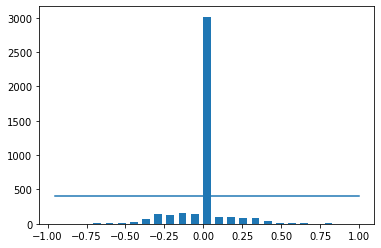

In [ ]:
num_bins= 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4161
removed: 2614
remaining: 1547


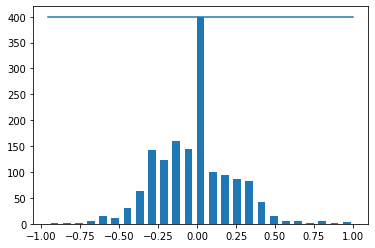

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2022_10_20_16_29_02_119.jpg
left        left_2022_10_20_16_29_02_119.jpg  
right       right_2022_10_20_16_29_02_119.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000078                          
Name: 13, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1237
Valid Samples: 310


Text(0.5, 1.0, 'Validation set')

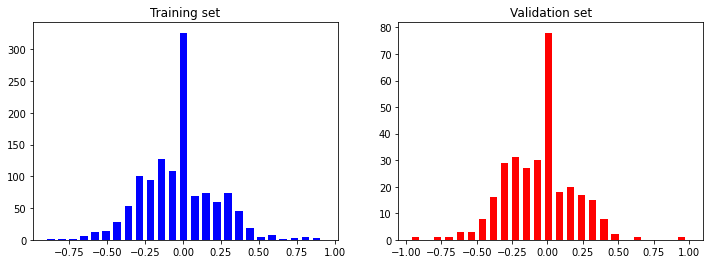

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

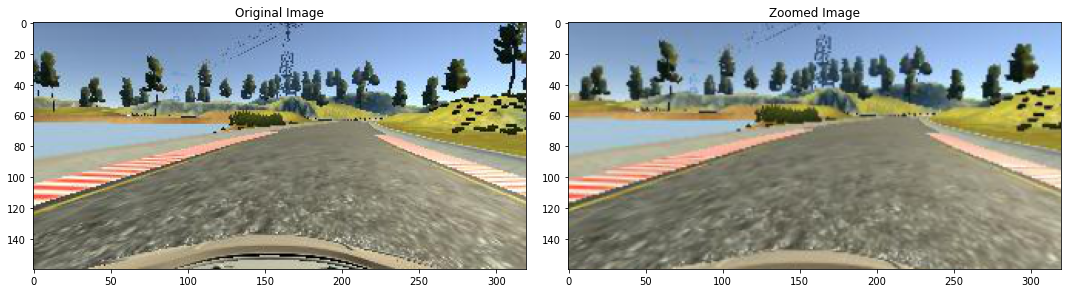

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

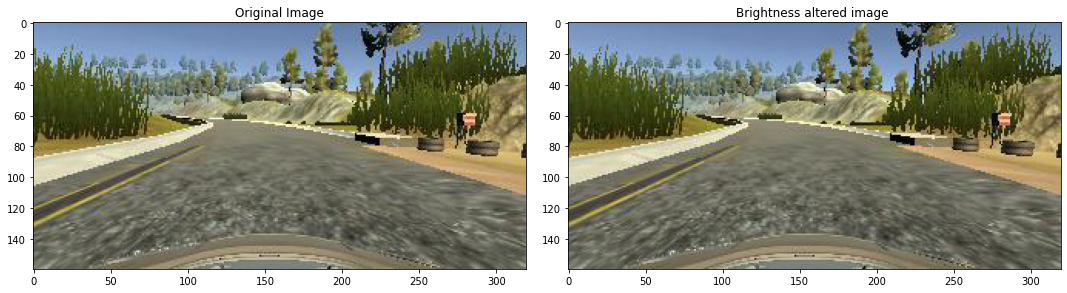

In [ ]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.0')

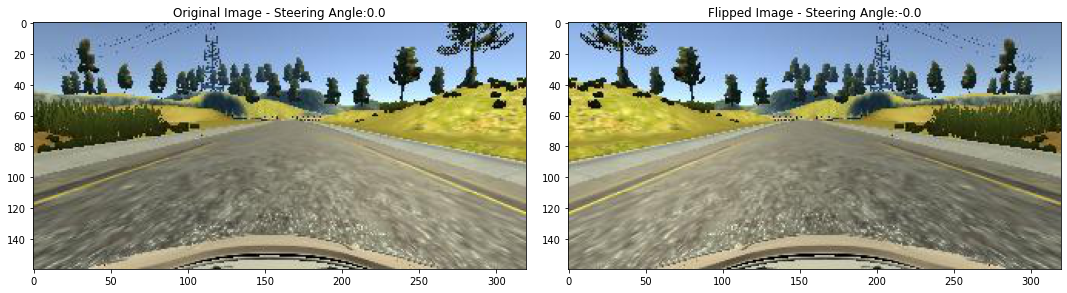

In [ ]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

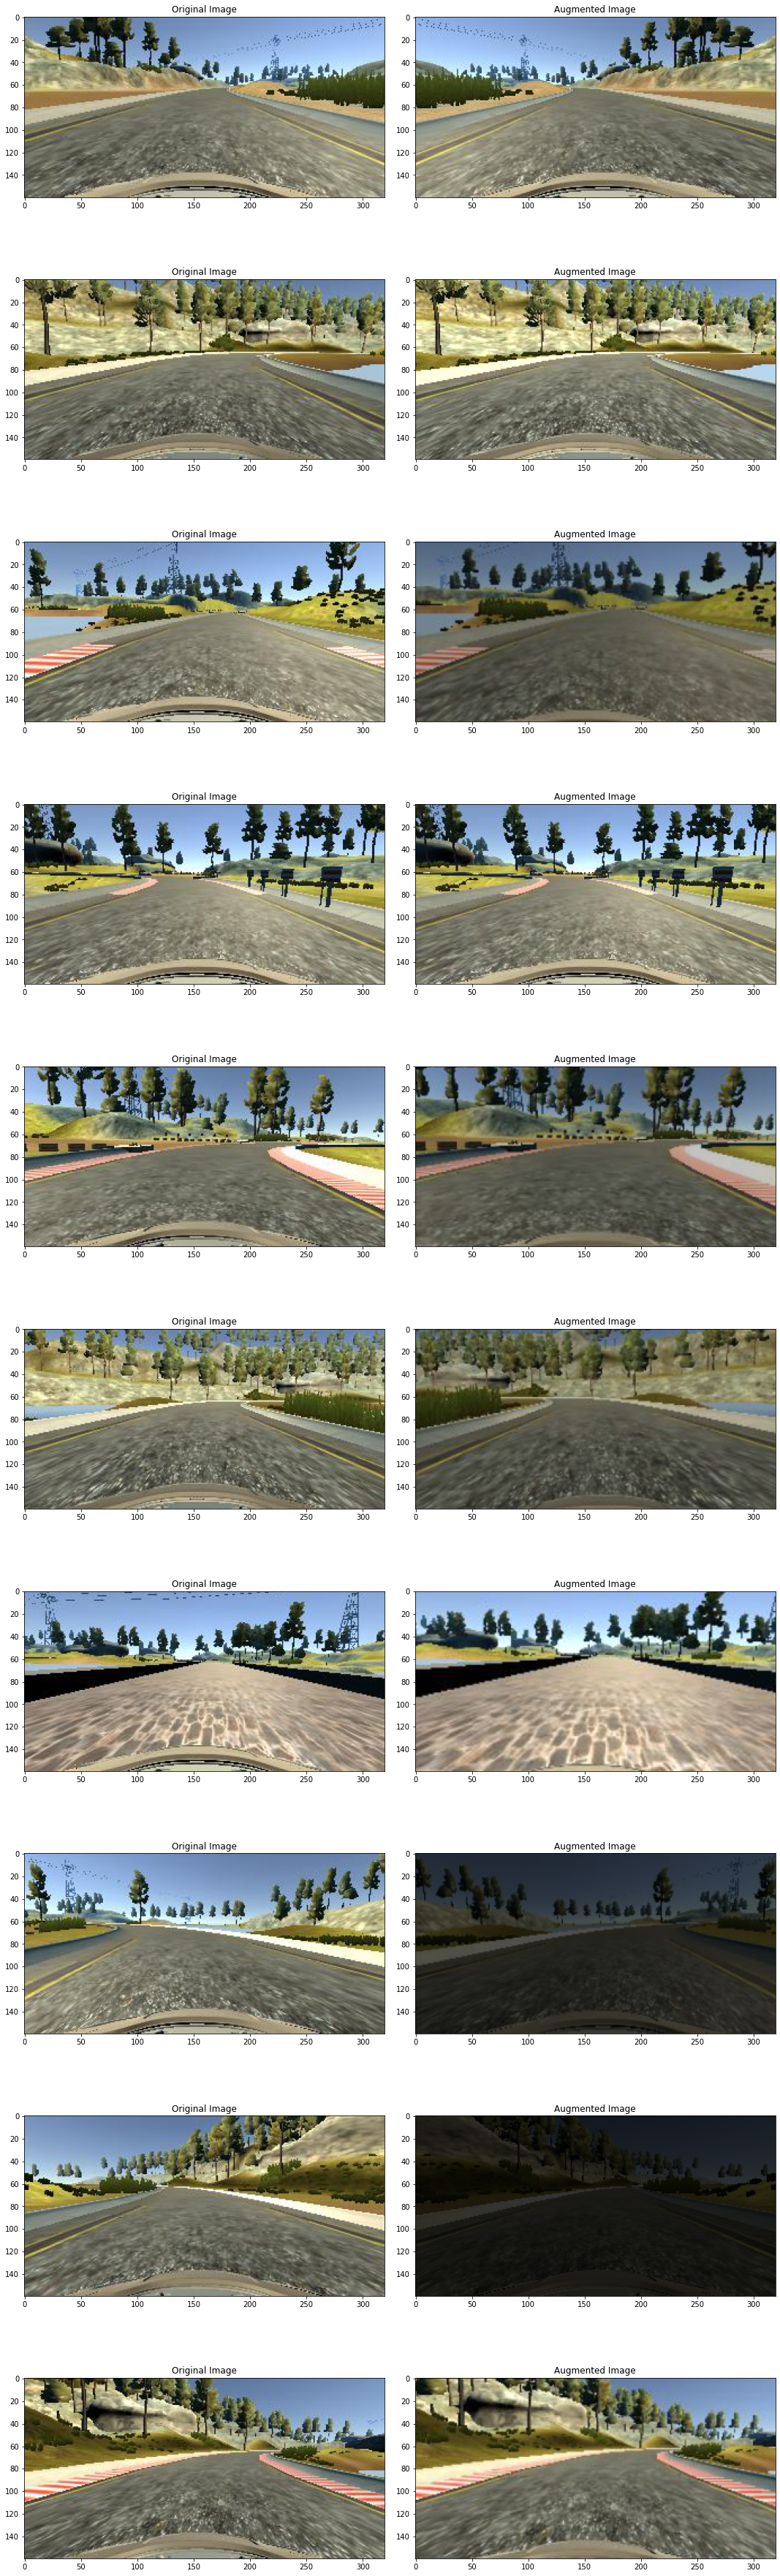

In [ ]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

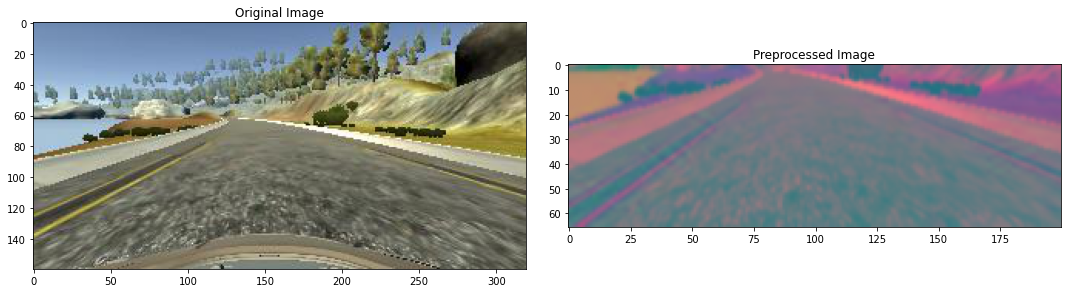

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

Text(0.5, 1.0, 'Validation Image')

In [ ]:
# def model():
#   model = Sequential()
#   model.add(Convolution2D(24, 5, 5, strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
#   model.add(Convolution2D(36, 5, 5, strides=(2, 2), activation='elu'))
#   model.add(Convolution2D(48, 5, 5, strides=(2, 2), activation='elu'))
#   model.add(Convolution2D(64, 3, 3, activation='elu'))
  
#   model.add(Convolution2D(64, 3, 3, activation='elu'))
  
#   model.add(Flatten())
  
#   model.add(Dense(100, activation = 'elu'))
  
#   model.add(Dense(50, activation = 'elu'))
  
#   model.add(Dense(10, activation = 'elu'))

#   model.add(Dense(1))
  
#   optimizer = Adam(lr=1e-4)
#   model.compile(loss='mse', optimizer=optimizer)
#   return model

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides= (2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides= (2,2), activation= 'elu'))
  model.add(Convolution2D(48, (5, 5), strides= (2,2), activation= 'elu'))
  model.add(Convolution2D(64, (3, 3),  activation='elu'))
  model.add(Convolution2D(64, (3, 3),  activation= 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100 , activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50 , activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10 , activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model



In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
300/300 [==============================] - 115s 379ms/step - loss: 0.1009 - val_loss: 0.0502
Epoch 2/10
300/300 [==============================] - 108s 361ms/step - loss: 0.0627 - val_loss: 0.0444
Epoch 3/10
300/300 [==============================] - 108s 360ms/step - loss: 0.0557 - val_loss: 0.0395
Epoch 4/10
300/300 [==============================] - 108s 361ms/step - loss: 0.0495 - val_loss: 0.0360
Epoch 5/10
300/300 [==============================] - 108s 361ms/step - loss: 0.0468 - val_loss: 0.0351
Epoch 6/10
300/300 [==============================] - 106s 355ms/step - loss: 0.0445 - val_loss: 0.0350
Epoch 7/10
300/300 [==============================] - 106s 356ms/step - loss: 0.0422 - val_loss: 0.0345
Epoch 8/10
300/300 [==============================] - 106s 356ms/step - loss: 0.0414 - val_loss: 0.0352
Epoch 9/10
300/300 [==============================] - 106s 354ms/step - loss: 0.0402 - val_loss: 0.0339
Epoch 10/10
300/300 [==============================] - 106s 354m

Text(0.5, 0, 'Epoch')

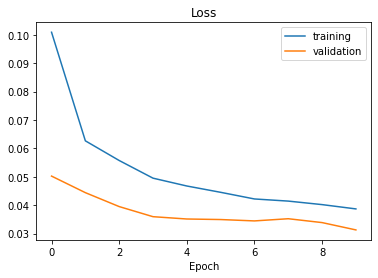

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_39 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_16 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_7 (Flatten)         (None, 1152)            

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>